 some soruce https://github.com/sarahmfrost/compostnet/blob/master/compostnet.ipynb



other source https://github.com/Hvass-Labs/TensorFlow-Tutorials

IncpetV4_20201019-101814

# Imports



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing split-folders for the split ratio

In [ ]:
 # !pip install split-folders
 # import splitfolders

### TensorBoard

Using TensorBoard tool to mantain logs

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
from datetime import datetime
from packaging import version

Matplotlib

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.image import ResizeMethod
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from IPython import get_ipython
# ipy = get_ipython()
# if ipy is not None:
#   ipy.run_line_magic('matplotlib', 'inline')

In [ ]:
from keras.callbacks import CSVLogger

In [ ]:
# !pip install livelossplot
# from livelossplot import PlotLossesKeras

## Global variables

In [ ]:
IMAGE_WIDTH, IMAGE_HEIGHT = 299, 299
EPOCHS = 80
BATCH_SIZE = 32
BASE_DIR = '/content/drive/My Drive/trash/'

Load images and split train\val\test

In [ ]:
DATA_DIR = BASE_DIR+ "ds_compostNet/"
OUT_DIR = BASE_DIR+ "ds_compostNet_split/"

!ls /content/drive/My\ Drive/split_compostNet

os.chdir(OUT_DIR)

!ls

ls: cannot access '/content/drive/My Drive/split_compostNet': No such file or directory
test  train  val


In [ ]:
# splitfolders.ratio(DATA_DIR, output= OUT_DIR, seed=1337, ratio=(.7, .13, .17), group_prefix=None)

Paths for train, val and test

In [ ]:
train_path = OUT_DIR+'train'
valid_path = OUT_DIR+'val'
test_path = OUT_DIR+'test'

# Helper functions

## Helper function to plot batches

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 16, figsize=(50,50))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


## Helper function for confusion matrix

In [ ]:
# plot the confusion matrix (scikit-learn copied)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data preparation 

## Data augmentation and preprocessing 

In [ ]:
train_generator = ImageDataGenerator(
    # rescale =  1./255,    
      #factor that permits to work with numbers beetween 0-1 and not 1-255; this is multiplied by every pixel value, 
      # is useless because of the preprocessing applied
    rotation_range = 15,  #degrees of random rotation applied
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

valid_generator = ImageDataGenerator(   
    rotation_range = 15,  
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

test_generator = ImageDataGenerator(
    rotation_range = 15,  
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

## Build batches from augmented images

In [ ]:
train_batches = train_generator.flow_from_directory(
    directory=train_path,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
    batch_size=BATCH_SIZE)

valid_batches = valid_generator.flow_from_directory(
    directory=valid_path,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
    batch_size=BATCH_SIZE)

test_batches = test_generator.flow_from_directory(
    directory=test_path, 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
    batch_size=BATCH_SIZE, 
    shuffle=False) 

Found 1922 images belonging to 7 classes.
Found 355 images belonging to 7 classes.
Found 474 images belonging to 7 classes.


## Display examples from the dataset

Display one of the augmented images in training set to see if  it'*s* modified correctly

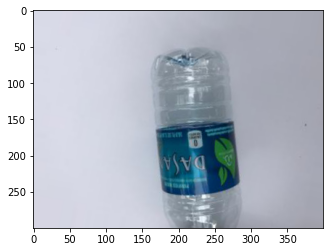

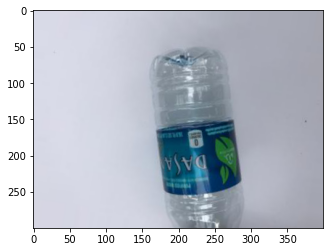

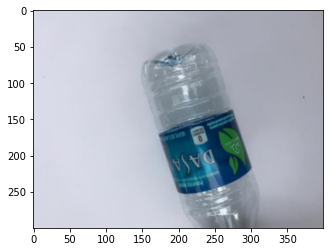

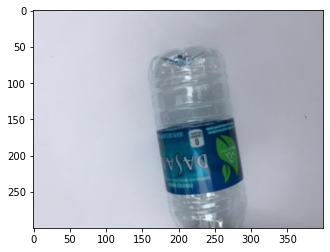

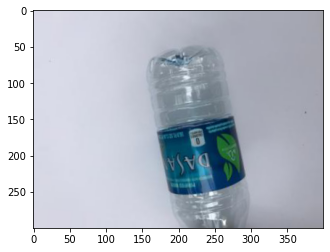

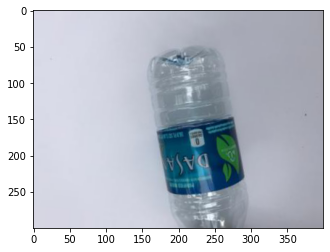

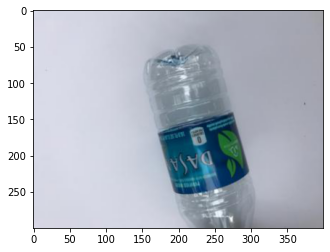

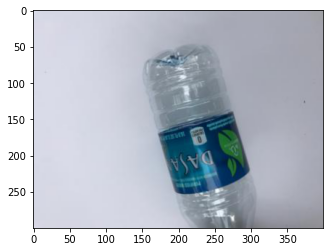

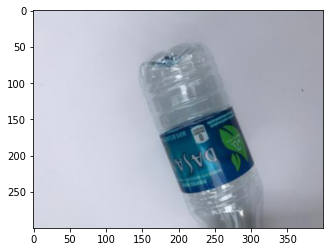

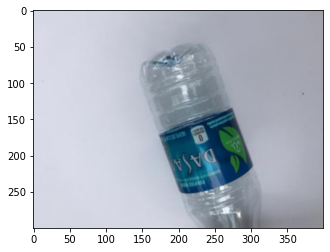

In [ ]:
img = load_img('train/plastic/plastic100.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_generator.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 10 == 0:
    break

Display train batch (half)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

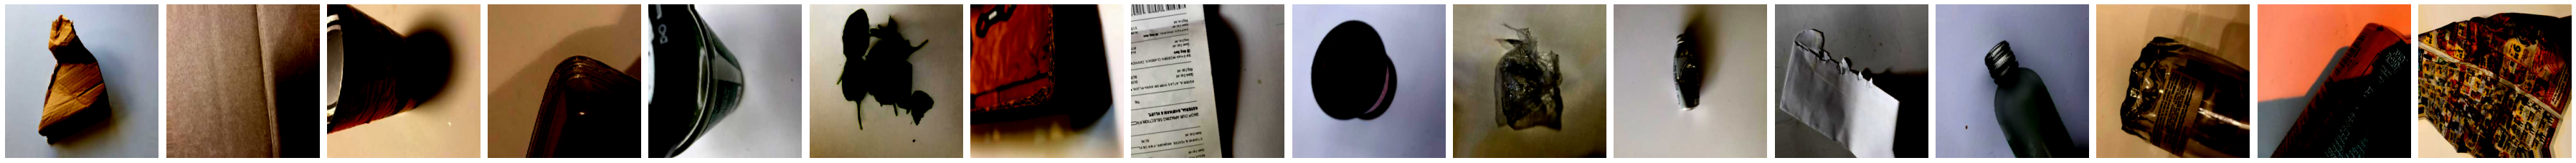

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
imgs, labels = next(train_batches)

plotImages(imgs)
print(labels)

# Model (InceptionResNetV2)

## Set the TensorBorad log directory

In [ ]:
os.chdir(BASE_DIR)

logdir = "logs/scalars/IncpetV4_" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


## Building the model

Download of the base model

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False, # we don't want the top layer (1000 image classifier)
    weights="imagenet", # transfer learning
)

In [ ]:
print(base_model.output)

Tensor("conv_7b_ac/Relu:0", shape=(None, None, None, 1536), dtype=float32)


In [ ]:
# copied and modified from https://keras.io/api/applications/

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer (7 classes)
predictions = Dense(7, activation='softmax')(x)



In [ ]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# freezing base model
for layer in base_model.layers:
  layer.trainable = False


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Fit and train

In [ ]:
history = model.fit(train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=EPOCHS,
          verbose=2,
          callbacks=[tensorboard_callback]
)

# time: 1h 12m

Epoch 1/80
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
61/61 - 57s - loss: 1.0031 - categorical_accuracy: 0.6831 - precision: 0.8932 - recall: 0.4178 - val_loss: 0.6001 - val_categorical_accuracy: 0.8197 - val_precision: 0.9087 - val_recall: 0.6732
Epoch 2/80
61/61 - 52s - loss: 0.5523 - categorical_accuracy: 0.8221 - precision: 0.8794 - recall: 0.7248 - val_loss: 0.4794 - val_categorical_accuracy: 0.8620 - val_precision: 0.9109 - val_recall: 0.7775
Epoch 3/80
61/61 - 52s - loss: 0.4527 - categorical_accuracy: 0.8502 - precision: 0.8968 - recall: 0.7908 - val_loss: 0.4352 - val_categorical_accuracy: 0.8535 - val_precision: 0.8875 - val_recall: 0.8000
Epoch 4/80
61/61 - 52s - loss: 0.3902 - categorical_accuracy: 0.8788 - precision: 0.9108 - recall: 0.8283 - val_loss: 0.4030 - val_categorical_accuracy: 0.8901 - val_precision: 0.9211 - val_recall: 0.8225
Epoch 5/80
61/61 - 52s - loss: 0.3509 - categorical_accuracy: 0.8814 - precision: 0.9177 - recall: 0.8413 - 

In [ ]:
print("Training stats:")
loss, acc, prec, rec = model.evaluate(train_batches, steps = len(train_batches))
print("Validation stats:")
loss, acc, prec, rec = model.evaluate(valid_batches, steps = len(valid_batches))

Training stats:
61/61 [==============================] - 43s 710ms/step - loss: 0.0114 - categorical_accuracy: 0.9984 - precision: 0.9990 - recall: 0.9984
Validation stats:
12/12 [==============================] - 7s 620ms/step - loss: 0.3267 - categorical_accuracy: 0.8930 - precision: 0.9023 - recall: 0.8845


## TensorBoard Graphs

In [ ]:
%tensorboard --logdir logs/scalars/IncpetV4_20201019-130320


## Save model


In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('CompostNet_inceptV4_model_revisione.h5') 

# Load model

In [ ]:
os.chdir(BASE_DIR)
!ls

CompostNet_inceptV4_model_revisione.h5	ds_trashnet_resized
ds_compostNet				ds_trashnet_split
ds_compostNet_split			report_AN_TN.csv
ds_mytest				TrashNet_AlexNet_revisione_model.h5
ds_mytest_AN


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('CompostNet_inceptV4_model_revisione.h5')

# Show the model architecture
model.summary()

print("Training stats:")
loss, acc, prec, rec = model.evaluate(train_batches, steps = len(train_batches))
print("Validation stats:")
loss, acc, prec, rec = model.evaluate(valid_batches, steps = len(valid_batches))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Predictions

In [ ]:
# test_imgs, test_labels = next(test_batches)
    # estrae immagini con corrispondenti label; ricorda che il test set è ordinato
# plotImages(test_imgs)
# print(test_labels)

In [ ]:
# generates predictions on the test set
preds = model.predict(x=test_batches, steps=len(test_batches), verbose=1)

15/15 [==============================] - 117s 8s/step


In [ ]:
# shows rounded predictions
# np.round(preds)

## Plots and results

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(preds, axis=-1))
    # np.argmax transform the one hot encoded labels in 1 or 0 to be
    # in the same format as the true labels
# access to the true labels in the test set
test_batches.classes


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

Confusion matrix, without normalization
[[62  0  0  0  7  0  0]
 [ 0 26  0  0  2  2  1]
 [ 0  0 76  5  0  5  0]
 [ 0  0  4 62  0  4  0]
 [ 2  0  0  0 95  0  5]
 [ 1  0 10  2  5 64  1]
 [ 0  2  0  3  5  3 20]]


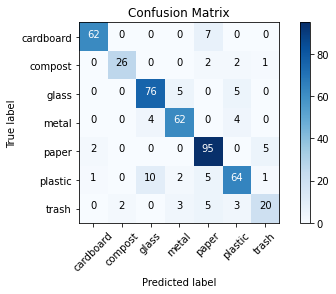

In [ ]:
cm_plot_labels = ['cardboard', 'compost', 'glass','metal', 'paper', 'plastic', 'trash']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
result = model.evaluate(test_batches, steps = len(test_batches))

15/15 [==============================] - 11s 717ms/step - loss: 0.5579 - categorical_accuracy: 0.8481 - precision: 0.8602 - recall: 0.8439


In [ ]:
print("Test-set categorical accuracy: {0:.2%}".format(result[1]))
print("Precision: {0:.2%}".format(result[2]))
print("Recall: {0:.2%}".format(result[3]))


Test-set categorical accuracy: 84.81%
Precision: 86.02%
Recall: 84.39%


In [ ]:
#classification report of precision and recall for each class
print(test_batches.class_indices)
print(classification_report(y_true=test_batches.classes, y_pred=np.argmax(preds, axis=-1)))
report = classification_report(y_true=test_batches.classes, y_pred=np.argmax(preds, axis=-1), output_dict= True)

{'cardboard': 0, 'compost': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        69
           1       0.93      0.84      0.88        31
           2       0.84      0.88      0.86        86
           3       0.86      0.89      0.87        70
           4       0.83      0.93      0.88       102
           5       0.82      0.77      0.80        83
           6       0.74      0.61      0.67        33

    accuracy                           0.85       474
   macro avg       0.85      0.83      0.84       474
weighted avg       0.85      0.85      0.85       474



In [ ]:
import pandas as pd 

df = pd.DataFrame(report).transpose()
df.to_csv('report_IV4_TN.csv', index = False)

# Test with my own dataset

In [ ]:
os.chdir(BASE_DIR)

In [ ]:
my_test_path = BASE_DIR + 'ds_mytest/'

my_test_batches = test_generator.flow_from_directory(
    directory= my_test_path, 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
    batch_size=BATCH_SIZE, 
    shuffle=False) 

Found 113 images belonging to 7 classes.


In [ ]:
# estrae immagini con corrispondenti label; ricorda che il test set è ordinato
my_test_imgs, my_test_labels = next(my_test_batches)

# plotImages(my_test_imgs)
# print(my_test_labels)

In [ ]:
# generates predictions on the test set
my_preds = model.predict(x=my_test_batches, steps=len(my_test_batches), verbose=1)

4/4 [==============================] - 33s 11s/step


In [ ]:
# shows rounded predictions
# np.round(preds)

## Plots and results

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true=my_test_batches.classes, y_pred=np.argmax(my_preds, axis=-1))
    # np.argmax transform the one hot encoded labels in 1 or 0 to be
    # in the same format as the true labels
# access to the true labels in the test set
my_test_batches.classes


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6], dtype=int32)

Confusion matrix, without normalization
[[10  0  0  0  5  0  0]
 [ 1  8  0  1  5  1  3]
 [ 0  0  7  0  1  3  0]
 [ 0  0  2  5  1  1  2]
 [ 6  0  0  0  9  0  0]
 [ 6  0  1  2  8  5  4]
 [ 2  0  1  4  7  0  2]]


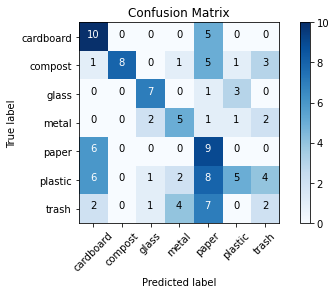

In [ ]:
cm_plot_labels = ['cardboard', 'compost', 'glass','metal', 'paper', 'plastic', 'trash']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
result = model.evaluate(my_test_batches, steps = len(my_test_batches))
print("My test-set categorical accuracy: {0:.2%}".format(result[1]))
print("Precision: {0:.2%}".format(result[2]))
print("Recall: {0:.2%}".format(result[3]))

4/4 [==============================] - 3s 620ms/step - loss: 3.4367 - categorical_accuracy: 0.3982 - precision: 0.4019 - recall: 0.3805
My test-set categorical accuracy: 39.82%
Precision: 40.19%
Recall: 38.05%


In [ ]:
#classification report of precision and recall for each class
print(my_test_batches.class_indices)
print()
print(classification_report(y_true=my_test_batches.classes, y_pred=np.argmax(my_preds, axis=-1)))
report = classification_report(y_true=my_test_batches.classes, y_pred=np.argmax(my_preds, axis=-1), output_dict= True)

{'cardboard': 0, 'compost': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}

              precision    recall  f1-score   support

           0       0.40      0.67      0.50        15
           1       1.00      0.42      0.59        19
           2       0.64      0.64      0.64        11
           3       0.42      0.45      0.43        11
           4       0.25      0.60      0.35        15
           5       0.50      0.19      0.28        26
           6       0.18      0.12      0.15        16

    accuracy                           0.41       113
   macro avg       0.48      0.44      0.42       113
weighted avg       0.50      0.41      0.40       113



In [ ]:
import pandas as pd 

df = pd.DataFrame(report).transpose()
df.to_csv('report_IV4_Test.csv', index = False)

In [ ]:
PRED_DIR = BASE_DIR + '/predictions'
os.chdir(PRED_DIR)

# Test: background augmentation

In [ ]:
os.chdir(BASE_DIR)

In [ ]:
bg_test_path = BASE_DIR + 'ds_trashnet_new_bg/'

bg_test_batches = test_generator.flow_from_directory(
    directory= bg_test_path, 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
    batch_size=BATCH_SIZE, 
    shuffle=False) 

Found 113 images belonging to 7 classes.


In [ ]:
# estrae immagini con corrispondenti label; ricorda che il test set è ordinato
bg_test_imgs, bg_test_labels = next(bg_test_batches)

# plotImages(my_test_imgs)
# print(my_test_labels)

In [ ]:
# generates predictions on the test set
bg_preds = model.predict(x=bg_test_batches, steps=len(bg_test_batches), verbose=1)

4/4 [==============================] - 33s 11s/step


In [ ]:
## shows rounded predictions
# np.round(preds)

## Plots and results

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true=my_test_batches.classes, y_pred=np.argmax(my_preds, axis=-1))
    # np.argmax transform the one hot encoded labels in 1 or 0 to be
    # in the same format as the true labels

# access to the true labels in the test set
my_test_batches.classes 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6], dtype=int32)

Confusion matrix, without normalization
[[10  0  0  0  5  0  0]
 [ 1  8  0  1  5  1  3]
 [ 0  0  7  0  1  3  0]
 [ 0  0  2  5  1  1  2]
 [ 6  0  0  0  9  0  0]
 [ 6  0  1  2  8  5  4]
 [ 2  0  1  4  7  0  2]]


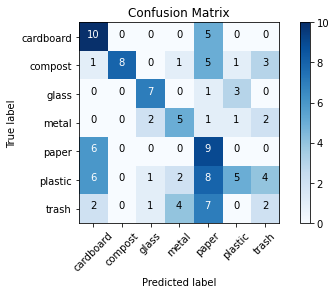

In [ ]:
cm_plot_labels = ['cardboard', 'compost', 'glass','metal', 'paper', 'plastic', 'trash']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
result = model.evaluate(my_test_batches, steps = len(bg_test_batches))
print("Categorical accuracy: {0:.2%}".format(result[1]))
print("Precision: {0:.2%}".format(result[2]))
print("Recall: {0:.2%}".format(result[3]))
print("F1: {0:.2%}".format(result[4]))

4/4 [==============================] - 3s 620ms/step - loss: 3.4367 - categorical_accuracy: 0.3982 - precision: 0.4019 - recall: 0.3805
My test-set categorical accuracy: 39.82%
Precision: 40.19%
Recall: 38.05%


In [ ]:
#classification report of precision and recall for each class
print(bg_test_batches.class_indices)
print()
print(classification_report(y_true=bg_test_batches.classes, y_pred=np.argmax(bg_preds, axis=-1)))
report = classification_report(y_true=bg_test_batches.classes, y_pred=np.argmax(bg_preds, axis=-1), output_dict= True)

{'cardboard': 0, 'compost': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}

              precision    recall  f1-score   support

           0       0.40      0.67      0.50        15
           1       1.00      0.42      0.59        19
           2       0.64      0.64      0.64        11
           3       0.42      0.45      0.43        11
           4       0.25      0.60      0.35        15
           5       0.50      0.19      0.28        26
           6       0.18      0.12      0.15        16

    accuracy                           0.41       113
   macro avg       0.48      0.44      0.42       113
weighted avg       0.50      0.41      0.40       113



In [ ]:
import pandas as pd 

df = pd.DataFrame(report).transpose()
df.to_csv('report_IV4_BG.csv', index = False)

In [ ]:
PRED_DIR = BASE_DIR + '/predictions'
os.chdir(PRED_DIR)